# A simple binary problem: is there a legal move or not? - Average pooling

This is a simplified version in which the model only answers the question whether there is at least one legal move or not.

In [1]:
import sys
sys.path.append(sys.path[0] + '/../cpp/bin')

import PyMorpionSolitaire

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange

## Data generation

This function plays one game at random until there are no more moves, stores the grid as `grid1`, then rewinds the game to an interemediate stage, and stores the resulting grid as `grid2`. The output of the function is a tensor containing the two grids. By construction the first grid has no legal moves and the second one has at least one legal move.

1/3 of the time the game is taken back to an arbitrary intermediate step.
The other 2/3 of the time we rewind the game by only one step, so that the network gets used to identify a single allowed move. If we did not do that the training process would result in a relatively high accuracy by only identifying some types of allowed moves instead of all of them.

In [3]:
def play_one_game(host = 0): # dummy argument needed for passing to pool.map
    game = PyMorpionSolitaire.Game5T('c');
    game.playAtRandom()
    grid1 = game.image()[48:144, 48:144]
    if np.random.randint(3) == 0:
        game.undo(np.random.randint(game.getScore() - 1) + 2)
    else:
        game.undo()
    grid2 = game.image()[48:144, 48:144]
    return np.stack((grid1, grid2))

Mini-batches contains a certain number of grids obtained in the way described above (computed in parallel to gain time), as well as a labels (0 for no legal moves, 1 for at least one legal move).

In [4]:
def generate_batch(batch_size = 200):
    x = []
    for _ in range(batch_size // 2):
        x.append(play_one_game())
    x = torch.tensor(np.concatenate(x)).float().unsqueeze(1)
    y = torch.tensor([0.,1.]).repeat(batch_size // 2).unsqueeze(1)
    return x, y

## Example

In [5]:
x, y = generate_batch()

In [6]:
x.shape, y.shape

(torch.Size([200, 1, 96, 96]), torch.Size([200, 1]))

In [7]:
def visualize(x):
    return Image.fromarray(~np.array(torch.squeeze(x)).astype(bool))    

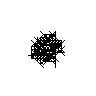

In [8]:
visualize(x[0])

In [9]:
y[0]

tensor([0.])

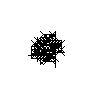

In [10]:
visualize(x[1])

In [11]:
y[1]

tensor([1.])

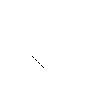

In [12]:
visualize(x[1]-x[0])

## Accuracy function

In [13]:
def accuracy(outputs, labels):
    return ((outputs > 0.5) == labels).float().mean()

## Model

We are going to use *transfer learning*: the convolutional layers are directly imported from a pre-trained model, while the rest of the network is initialized at random:

In [14]:
template = torch.load('models/Bacon.pt')
template.train()
template

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): AdaptiveMaxPool2d(output_size=1)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=40, out_features=10, bias=True)
  (12): ReLU()
  (13): Linear(in_features=10, out_features=1, bias=True)
)

In [15]:
modules = [template[i] for i in range(9)]
modules.extend([torch.nn.ReLU(),
                torch.nn.AdaptiveAvgPool2d(1),
                torch.nn.Flatten(),
                torch.nn.Linear(40, 20),
                torch.nn.ReLU(),
                torch.nn.Linear(20, 10),
                torch.nn.ReLU(),
                torch.nn.Linear(10, 1)])
net = torch.nn.Sequential(*modules)
net

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=40, out_features=20, bias=True)
  (13): ReLU()
  (14): Linear(in_features=20, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=1, bias=True)
)

Number of parameters in the model:

In [16]:
sum(p.numel() for p in net.parameters())

23801

In [17]:
y_pred = net(x)
y_pred.shape

torch.Size([200, 1])

In [18]:
accuracy(y_pred, y)

tensor(0.5000)

## Training

In [19]:
loss_func = torch.nn.MSELoss()

In [20]:
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01)

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01, momentum=0.9)

In [22]:
running_loss_data = []
running_accuracy_data = []

In [23]:
epoch_size = 100
n_epochs = 200

running_loss = []
running_accuracy = []

for i in trange(n_epochs * epoch_size + 1):
    inputs, labels = generate_batch()
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss.append(loss.item())
    running_accuracy.append(accuracy(outputs, labels))
    if i % epoch_size == 0:
        running_loss_data.append(np.mean(running_loss))
        running_accuracy_data.append(np.mean(running_accuracy))
        print('[%6d] loss: %8.5f  accuracy: %5.3f' % (i, running_loss_data[-1], running_accuracy_data[-1]))
        running_loss = []
        running_accuracy = []

  0%|          | 0/20001 [00:00<?, ?it/s]

[     0] loss:  0.71794  accuracy: 0.500
[   100] loss:  0.27255  accuracy: 0.501
[   200] loss:  0.24999  accuracy: 0.538
[   300] loss:  0.24998  accuracy: 0.614
[   400] loss:  0.24998  accuracy: 0.623
[   500] loss:  0.24997  accuracy: 0.630
[   600] loss:  0.24997  accuracy: 0.630
[   700] loss:  0.24996  accuracy: 0.636
[   800] loss:  0.24996  accuracy: 0.635
[   900] loss:  0.24995  accuracy: 0.634
[  1000] loss:  0.24994  accuracy: 0.633
[  1100] loss:  0.24994  accuracy: 0.632
[  1200] loss:  0.24993  accuracy: 0.629
[  1300] loss:  0.24992  accuracy: 0.630
[  1400] loss:  0.24991  accuracy: 0.626
[  1500] loss:  0.24990  accuracy: 0.628
[  1600] loss:  0.24989  accuracy: 0.628
[  1700] loss:  0.24987  accuracy: 0.625
[  1800] loss:  0.24985  accuracy: 0.628
[  1900] loss:  0.24983  accuracy: 0.626
[  2000] loss:  0.24981  accuracy: 0.621
[  2100] loss:  0.24977  accuracy: 0.627
[  2200] loss:  0.24974  accuracy: 0.627
[  2300] loss:  0.24967  accuracy: 0.621
[  2400] loss:  

[ 20000] loss:  0.00581  accuracy: 0.994


In [24]:
torch.save(net, 'models/Descartes_binary.pt')

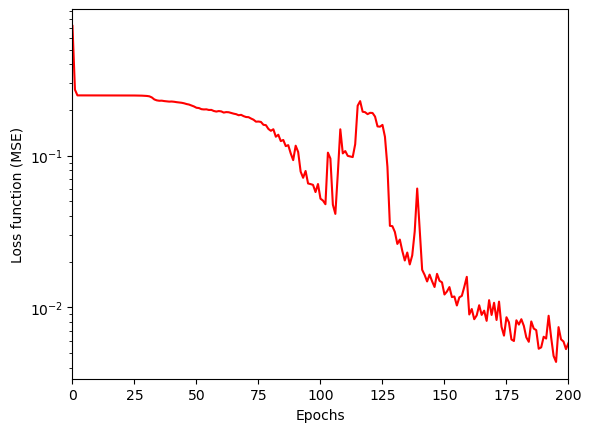

In [25]:
plt.plot(running_loss_data, color='red')
plt.xlabel('Epochs')
plt.xlim(0, len(running_loss_data) - 1)
plt.ylabel('Loss function (MSE)')
plt.yscale('log')
# plt.savefig('Descartes_binary_loss.png', bbox_inches='tight')
plt.show()

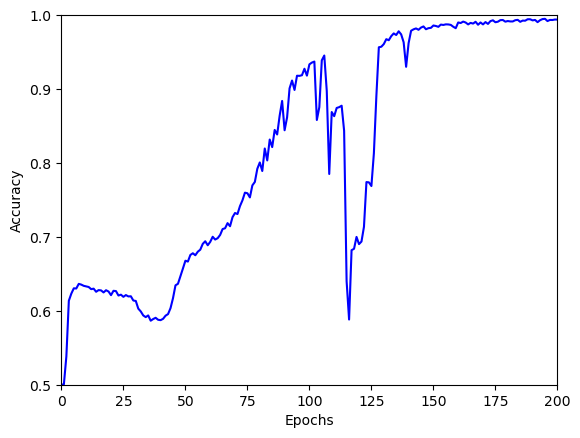

In [26]:
plt.plot(running_accuracy_data, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, len(running_accuracy_data) - 1)
plt.ylim(0.5, 1)
# plt.savefig('Descartes_binary_accuracy.png', bbox_inches='tight')
plt.show()

In [27]:
running_error_data = [1.0 - x for x in running_accuracy_data]

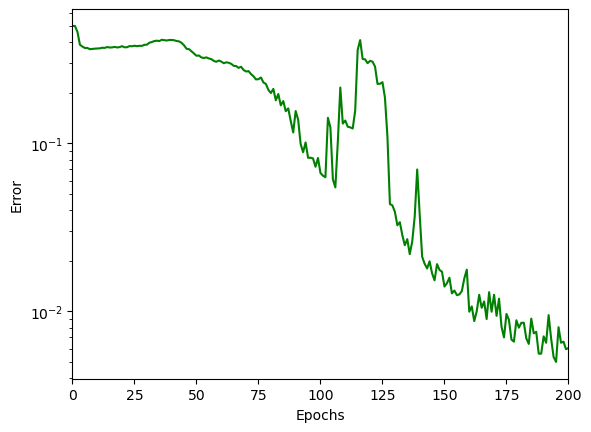

In [28]:
plt.plot(running_error_data, color='green')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.xlim(0, len(running_error_data) - 1)
plt.yscale('log')
plt.show()

## Loading the model

Once the model has been trained, this can be used to load its state dictionary:

In [29]:
net2 = torch.load('models/Descartes_binary.pt')
net2.eval()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=40, out_features=20, bias=True)
  (13): ReLU()
  (14): Linear(in_features=20, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=1, bias=True)
)

## Validation

In [30]:
x, y = generate_batch(1000)

In [31]:
y_preds = net2(x).data

In [32]:
accuracy(y_preds, y)

tensor(0.9990)

In [33]:
y.mean(), y.std(), y_preds.mean(), y_preds.std()

(tensor(0.5000), tensor(0.5003), tensor(0.4884), tensor(0.4843))

In [34]:
mistakes = []
for i in range(y.shape[0]):
    if (y_preds[i] > 0.5) != y[i]:
        mistakes.append([i, y[i].item(), y_preds[i].item()])
mistakes

[[663, 1.0, 0.11436343938112259]]

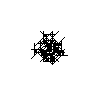

In [36]:
visualize(x[mistakes[0][0]])